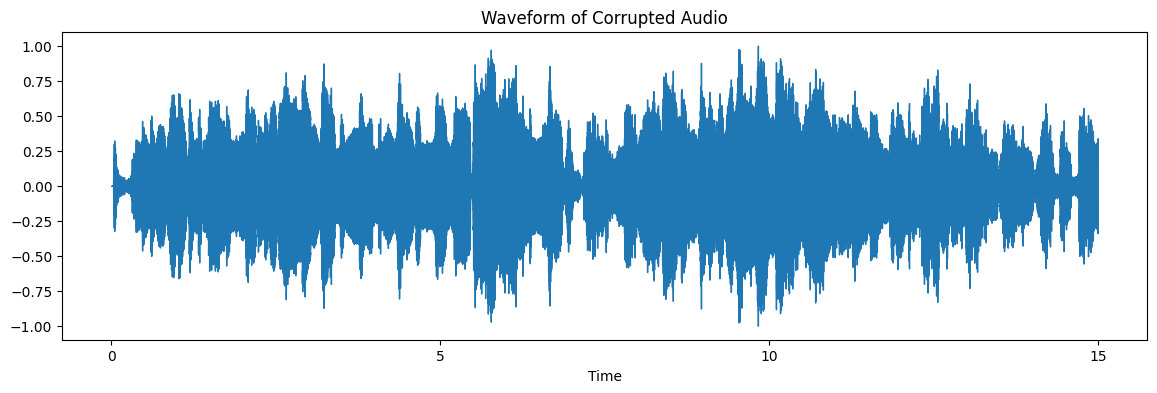

48000


In [508]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load the audio file
file_path = r'D:\EE200_practical_programming\EE200_practical_programming\song_with_2piccolo.wav'
y, sr = librosa.load(file_path, sr=None)

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Corrupted Audio')
plt.show()

print(sr)

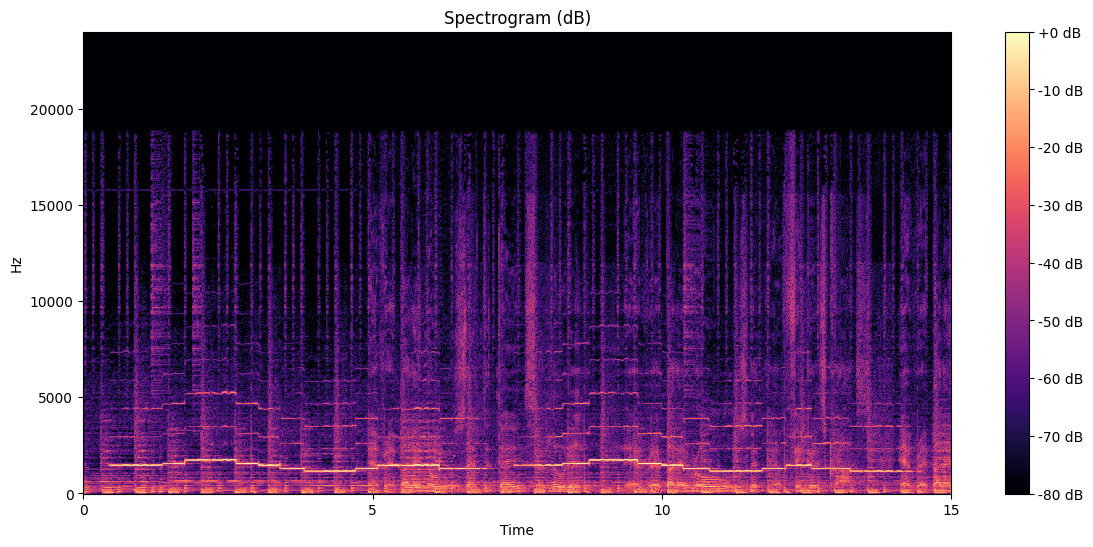

In [509]:
# STFT (Short-Time Fourier Transform)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.show()

Peak at 46.875 Hz with power 3.8818e-05
Peak at 1453.125 Hz with power 1.5792e-04


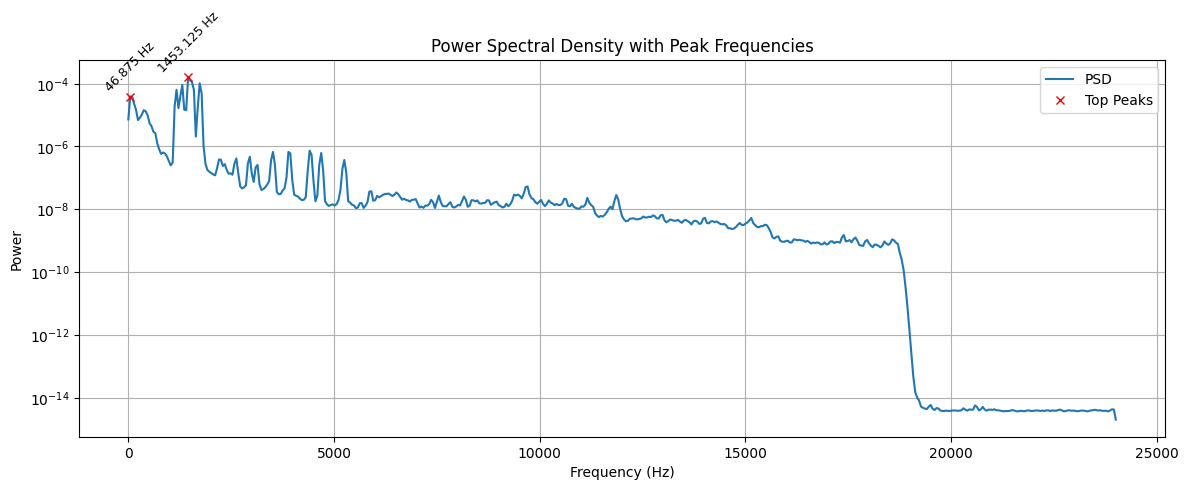

In [510]:
from scipy.signal import welch, find_peaks

f, Pxx = welch(y, fs=sr, nperseg=1024)

# Finding peaks
peaks, properties = find_peaks(Pxx, height=np.max(Pxx)*0.01, prominence=1e-6, distance=20)
peak_freqs = f[peaks]
peak_powers = Pxx[peaks]

# Getting top 5 peaks
top_indices = np.argsort(peak_powers)[-5:][::-1]
top_freqs = peak_freqs[top_indices]
top_powers = peak_powers[top_indices]
for idx in top_indices:
    print(f"Peak at {top_freqs[idx]:.3f} Hz with power {top_powers[idx]:.4e}")


# Plotting with labeled peaks
plt.figure(figsize=(12, 5))
plt.semilogy(f, Pxx, label="PSD")
plt.plot(top_freqs, top_powers, "rx", label="Top Peaks")
for freq, power in zip(top_freqs, top_powers):
    plt.text(freq, power*1.2, f"{freq:.3f} Hz", ha='center', va='bottom', fontsize=9, rotation=45)
plt.title("Power Spectral Density with Peak Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()
plt.grid(True)
plt.tight_layout()

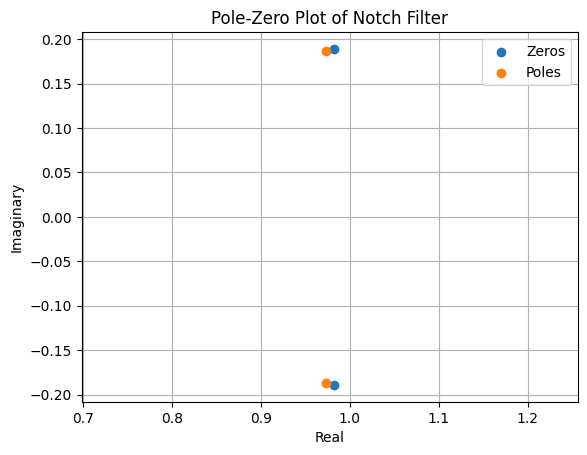

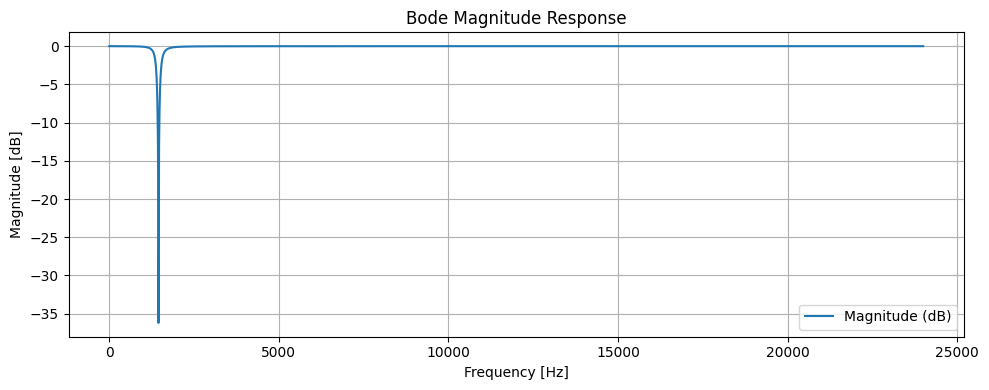

In [511]:
from scipy.signal import iirnotch, tf2zpk, freqz

# Notch filter to remove unwanted frequency components
f = 1453.125 # frequencies to remove (an example peak taken from PSD plot)
Q = 10.0   # Quality factor (controls the sharpness or bandwidth of the filter -- low value of Q means precise filtering)
b, a = iirnotch(f, Q, sr)

# Pole-zero plot corresponding to f1 = 1453.1 Hz
z, p, k = tf2zpk(b, a)
plt.figure()
plt.scatter(np.real(z), np.imag(z), label='Zeros')
plt.scatter(np.real(p), np.imag(p), label='Poles')
plt.title('Pole-Zero Plot of Notch Filter')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.legend()
plt.axis('equal')
plt.show()

# Bode plot (Narrow stop band around f1 = 1453.1 Hz to remove the unwanted sound)
w, h = freqz(b, a, worN=8000, fs=sr)  
plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(abs(h)), label="Magnitude (dB)")
plt.title("Bode Magnitude Response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [512]:
from scipy.signal import tf2sos
from scipy.signal import sosfiltfilt

# after a lot of experimentation and playing with my filter frequencies, I got these values from PSD plot where the unwanted solo instrument music might be located.
f1 = 1453.125  
f2 = 46.875
f3 = 1312.5
f4 = 1734.375
f5 = 1546.875
f6 = 1171.875
f7 = 1500
f8 = 93.75
f9 = 2000.0

# filtering the audio file 
freqs = [f1, f3, f4, f5, f6, f2]    # carefully choosen values of frequencies to remove the unwanted music and also maintain a pretty good audio quality.
harmonics = [f*i for i in range(1, 5) if f1 * i < sr / 2 for f in freqs]
print(harmonics)
sos_harmonics = []
for h in harmonics:
    b, a = iirnotch(h, Q, sr)
    sos = tf2sos(b, a)
    sos_harmonics.append(sos)
sos = np.vstack(sos_harmonics)
i = 0
filtered_y = sosfiltfilt(sos, y)
while(i<3):
    filtered_y = sosfiltfilt(sos, filtered_y)
    i=i+1

# Saving the restored audio file
import soundfile as sf
sf.write("restored_song.wav", filtered_y, sr)

[1453.125, 1312.5, 1734.375, 1546.875, 1171.875, 46.875, 2906.25, 2625.0, 3468.75, 3093.75, 2343.75, 93.75, 4359.375, 3937.5, 5203.125, 4640.625, 3515.625, 140.625, 5812.5, 5250.0, 6937.5, 6187.5, 4687.5, 187.5]


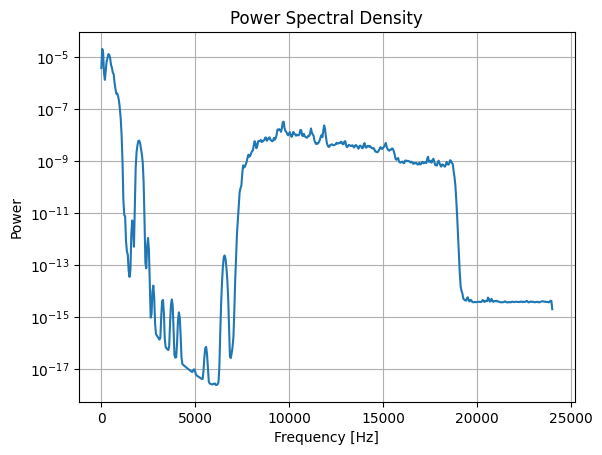

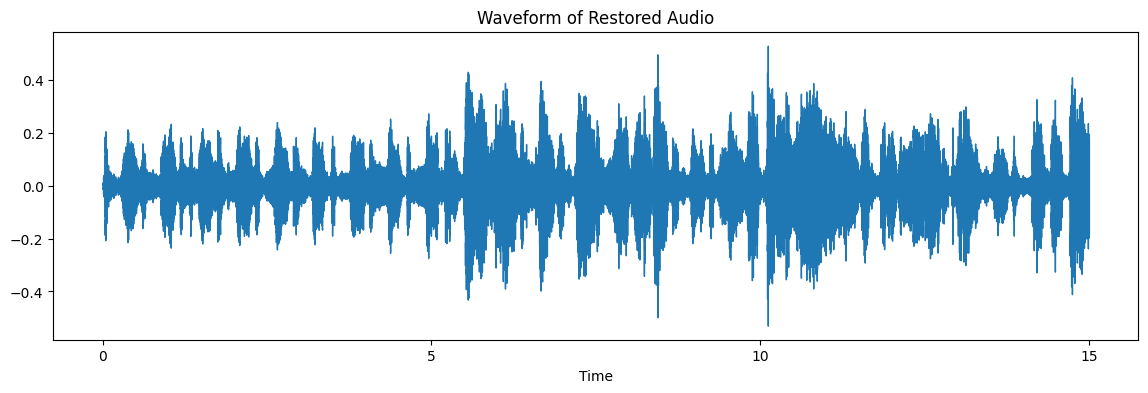

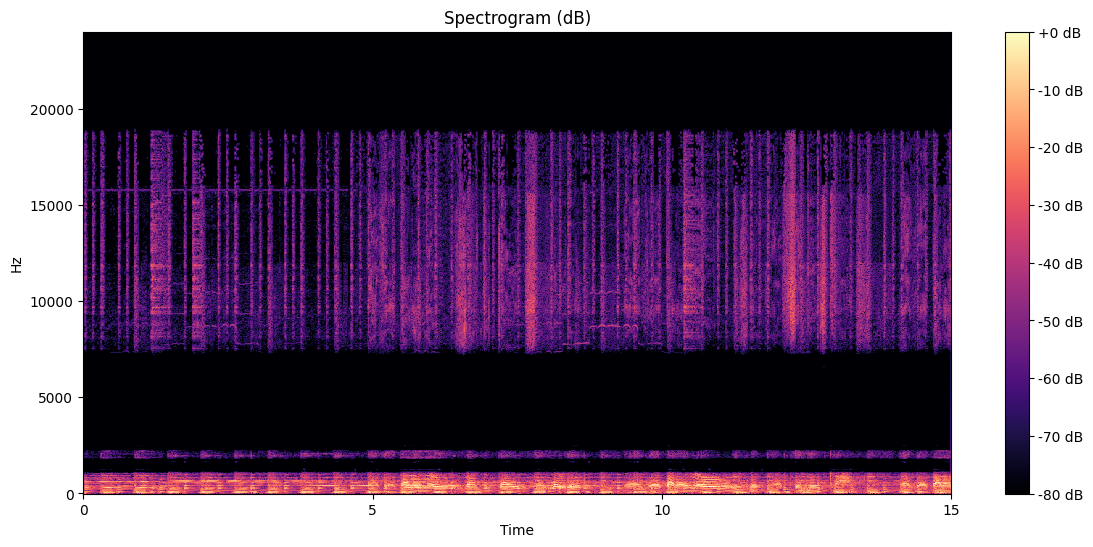

In [513]:
# To check whether the filtering was successful or  not.
f, Pxx = welch(filtered_y, fs=sr, nperseg=1024)
plt.semilogy(f, Pxx)
plt.title('Power Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.grid()
plt.show()

y_new, sr = librosa.load(r"D:\EE200_practical_programming\EE200_practical_programming\restored_song.wav", sr=None)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y_new, sr=sr)
plt.title('Waveform of Restored Audio')
plt.show()

d = librosa.stft(y_new)
s_db = librosa.amplitude_to_db(np.abs(d), ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(s_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.show()